In [2]:
import numpy as np

import data_io
import data_preprocessing
from implementations import *
import validation
import attribute_selection
import evaluators
import metrics

# Autoreload modules
%load_ext autoreload
%autoreload 2

In [14]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')

In [4]:

DATA_FILE_PREFIX = './data/'

In [5]:
y_train, x_train, _, cols = data_io.load_csv_data(f'{DATA_FILE_PREFIX}train.csv')
_, x_test, ids_test, cols_train = data_io.load_csv_data(f'{DATA_FILE_PREFIX}test.csv')

In [6]:
col_to_index_mapping = {col_name: index - 2 for index, col_name in enumerate(cols) if index >= 2}
y_train = (y_train + 1) // 2

In [7]:
import operator

def tune_lambda(y, x, grid, seed=42, history=True):
    w_init = np.zeros(x.shape[1])
    res = {}
    for lambda_ in grid:
        np.random.seed(seed)
        train_model = lambda y_, x_: make_predictor(reg_logistic_regression_sgd(
            y_, x_, lambda_, w_init, 5, 1000, 0.5,
        )[0])
        res[lambda_] = validation.cross_validation(y, x, train_model, 5)[0].mean()
        if history:
          print(f"{lambda_}: {res[lambda_]:.4f}")
    return max(res.items(), key=operator.itemgetter(1))

In [8]:
def make_predictor(w):
  def foo(features):
    return (features @ w > 0).astype(int)
  return foo

----

In [10]:
def build_pairwise(x, column_idx):
    """build pairwise multiplyed features x"""
    if x.ndim == 1:
        x = x[:, np.newaxis]
        
    columns = np.copy(x[:, column_idx])
    pairwise = []
    for i in range(columns.shape[1]):
        for j in range(i + 1, columns.shape[1]):
            pairwise.append(columns[:, i] * columns[:, j])
    pairwise = np.array(pairwise).T
    return pairwise

def build_pairwise_xy(x, y):
    """build pairwise multiplyed features x"""
    pairwise = []
    for i in range(x.shape[1]):
        for j in range(y.shape[1]):
            pairwise.append(x[:, i] * y[:, j])
    pairwise = np.array(pairwise).T
    return pairwise

In [11]:
def standardize(x):
    mean = np.mean(x, axis=0)
    std_dev = np.std(x, axis=0, ddof=1)
    std_dev[std_dev < 1e-6] = 1
    return (x - mean) / std_dev


In [318]:
def expit(x):
    exp_x = np.exp(x)
    return np.where(x >= 0,
                    1 / (1 + np.exp(-x)),
                    exp_x / (1 + exp_x))


def logistic_regression_grad(y, tx, weights, ratio=1.):
    p = expit(tx @ weights)
    g = (p - y)[:, None] * tx
    obj_w = ratio * y + (1 - y) * 1.
    return (g * obj_w[:, None]).mean(0)


def softplus(x):
    return np.where(x >= 30, x, np.log1p(np.exp(x)))


def logistic_regression_loss(y, tx, weights):
    t = 2 * y - 1
    loss = softplus(-t * (tx @ weights))
    return loss.mean()


def reg_logistic_regression_sgd(y, tx, lambda_, initial_w, n_epochs, batch_size, gamma, history=False, ratio=1.):
    weights = initial_w
    loss_h = [logistic_regression_loss(y, tx, weights)]

    for iteration in range(n_epochs):
        # Stochastic Gradient Descent step
        batches = batch_iter(y, tx, batch_size=batch_size, num_batches=len(y) // batch_size)
        for y_batch, tx_batch in batches:
            # calculate gradient
            g = logistic_regression_grad(y_batch, tx_batch, weights, ratio)
            # add L2 regularizer gradient (lambda_ * w^Tw)
            g += 2 * lambda_ * weights
            # make a GD step
            weights -= gamma * g

        loss_h.append(logistic_regression_loss(y, tx, weights))

    if not (1e-3 > 1 - loss_h[-1] / loss_h[-2] > -1e-3):
        warnings.warn("Logistic regression didn't converge!")

    return (weights, np.array(loss_h) if history else loss_h[-1])


In [566]:
x = np.copy(x_train)


CLIP = {}
NORMALIZATION = {}

def data_preproc(x, train=True):
    tx = np.copy(x) # Recommended to copy x so it doesn't change
    tx[tx == -999.] = np.nan
    features = {}

    # onehot for categorical and drop one level
    tx_categorical = (tx[:, 22][:, None] == np.arange(4)).astype(float)[:, :-1]
    for i in range(3):
        features[f'ohe_{i}'] = tx_categorical[:, i]

    # drop categorical feature
    tx = np.concatenate([tx[:, :22], tx[:, 23:]], 1)

    for i in range(tx.shape[1]):
        features[f'real_{i}'] = tx[:, i]

    df = pd.DataFrame(features)

    # drop features w/ lots of nans
#     df = df.drop(df.columns[df.isna().mean() > 0.7], axis=1)

    real_clmns = [c for c in df.columns if 'ohe' not in c]
    cat_clmns = [c for c in df.columns if 'ohe' in c]

    # %breakpoint
    # standartize data
    for c in real_clmns:
        if train:
            v = df[c].copy()
            v = v[~v.isna()]
            min_, max_ = v.min(), v.max()
            if v.max() / v.quantile(0.9) > 1.7:
                max_ = v.quantile(0.9)
            if v.min() / v.quantile(0.1) < 0.5 or v.min() / v.quantile(0.1) > 2:
                min_ = v.quantile(0.1)
            CLIP[c] = (min_, max_)
        df[c] = df[c].clip(CLIP[c][0], CLIP[c][1])


    # normalize features
    df[real_clmns] = standardize(df[real_clmns])

    # create is_nan features
    isnan_columns = df.columns[df.isna().any()]
    df = df.join(df[isnan_columns].isna().astype(float), rsuffix='_isna')
    # set missing values to 0
    df = df.fillna(0)

    poly = np.cos(df[real_clmns])
    df = df.join(poly, rsuffix='_cos')

#     poly = np.sin(df[real_clmns])
#     df = df.join(poly, rsuffix='_sin')

    real_clmns += (poly.columns + '_cos').tolist()

    # # add squares and pairwise mult
    tx_pairs_real = build_pairwise(df[real_clmns].to_numpy(), np.arange(len(real_clmns)))
    tx_pairs_real = standardize(tx_pairs_real)
    df = df.join(pd.DataFrame(tx_pairs_real), rsuffix='_pairs_real')

    # pairwise mult btw real and OHE
    tx_pairs_real_cat = build_pairwise_xy(df[real_clmns].to_numpy(), df[cat_clmns].to_numpy())
    tx_pairs_real_cat = standardize(tx_pairs_real_cat)
    df = df.join(pd.DataFrame(tx_pairs_real_cat), rsuffix='_pairs_real_cat')



    return np.concatenate([
        df.astype(float).to_numpy(),
        np.ones((df.shape[0], 1))
    ], 1)

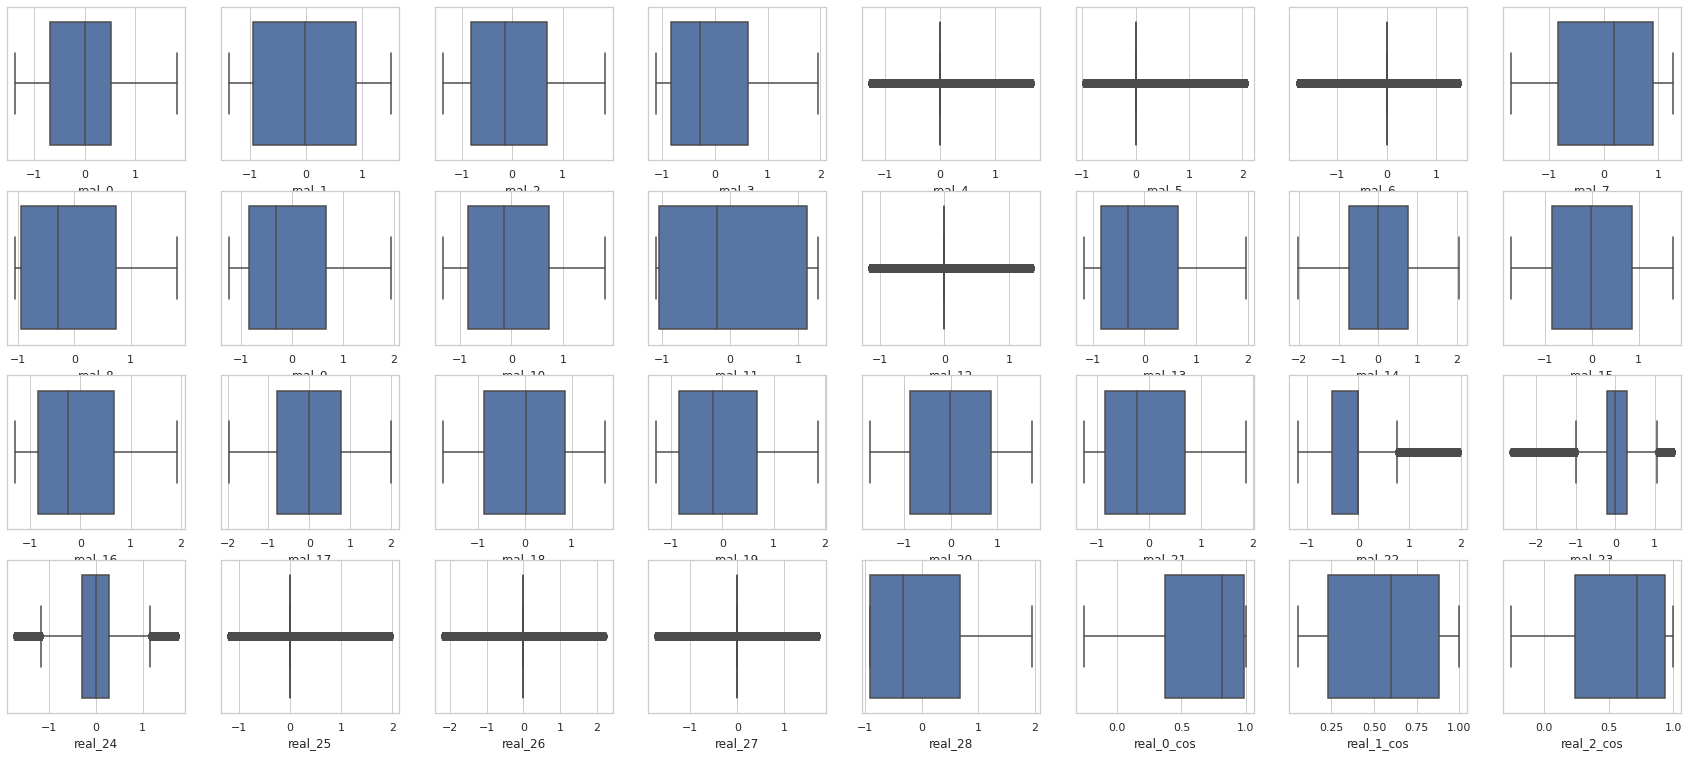

In [485]:
# f, axs = plt.subplots(4, 8, figsize=(30, 13))
# for c, ax in zip(real_clmns, axs.flatten()):
#     sns.boxplot(x=df[c], ax=ax)

Text(0.5, 0, '% missing values for a data point')

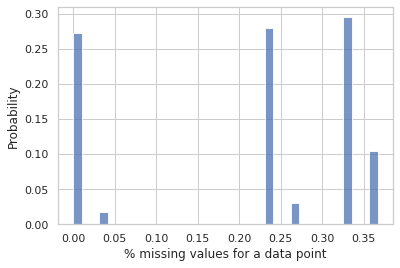

In [486]:
sns.histplot((x_train == -999).mean(1), stat='probability')
plt.xlabel('% missing values for a data point')

### Train model

## Ensemble 

In [567]:
x_train_al = data_preproc(x_train)

<ipython-input-566-8198b563574c>:40: RuntimeWarning: invalid value encountered in double_scalars
  if v.min() / v.quantile(0.1) < 0.5 or v.min() / v.quantile(0.1) > 2:


In [568]:
x_train_all.shape

(250000, 1900)

In [ ]:
def make_predictor_proba(w):
    def foo(features):
        return expit(features @ w)
    return foo

def ensemble_model(models):
    def foo(x):
        return (np.stack([m(x) for m in models]).mean(0) > 0.5).astype(int)
    return foo

np.random.seed(42)

models = []
for _ in range(5):
    idxs = np.random.permutation(np.arange(250000))[:200000]
    models.append(make_predictor_proba(reg_logistic_regression_sgd(
            y_train[idxs], x_train_all[idxs], 1e-11, np.zeros(x_train_all.shape[1]), 100, 2000, 0.1,
        )[0]))
ens_model = ensemble_model(models)

(ens_model(x_train_all) == y_train).mean(), [np.mean((m(x_train_all) > 0.5) == y_train) for m in models]

In [519]:
def mycreate_submission(predict, x_test, ids, train_model, file_name):
    full_file_name = f'{file_name}.csv'
    labels = predict(x_test)
    labels = labels * 2 - 1
    data_io.create_csv_submission(ids, labels, full_file_name)

In [ ]:
tx_test = data_preproc(x_test, train=False)
tx_test.shape

In [549]:
mycreate_submission(
    ens_model, 
    tx_test, 
    ids_test, None, 'ens_andrei')

---

In [ ]:
def tune_lambda(y, x, grid, seed=42, history=True):
#     w_init = np.zeros(x.shape[1])
    res = {}
    for lambda_ in grid:
        np.random.seed(seed)
        train_model = lambda y_, x_: make_predictor(reg_logistic_regression_sgd(
            y_, x_, lambda_, np.zeros(x.shape[1]), 20, 2000, 0.1,
        )[0])
        res[lambda_] = validation.cross_validation(y, x, train_model, 5)[0].mean()
        if history:
            print(f"{lambda_}: {res[lambda_]:.4f}")
    return max(res.items(), key=operator.itemgetter(1))

tune_lambda(y_train, x_train_all, [1e-8, 1e-9, 1e-10, 1e-11])